In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data loading

In [2]:
df_dev = load_dataset("csv", data_files="dataset/subtaskA_clean_dev_cased.csv")
df_test = load_dataset("csv", data_files="dataset/subtaskA_clean_test_cased.csv")

Found cached dataset csv (C:/Users/irene/.cache/huggingface/datasets/csv/default-9117625add939e31/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset csv (C:/Users/irene/.cache/huggingface/datasets/csv/default-3cb4956ee4561a2a/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


  0%|          | 0/1 [00:00<?, ?it/s]

# Data partioning

In [3]:
train_val = df_dev['train'].train_test_split(test_size=0.3, seed=42) # inserire random state
train_val

DatasetDict({
    train: Dataset({
        features: ['Id', 'comment_text', 'conspiratorial'],
        num_rows: 1289
    })
    test: Dataset({
        features: ['Id', 'comment_text', 'conspiratorial'],
        num_rows: 553
    })
})

In [4]:
df_train = train_val["train"]
df_val = train_val["test"]

In [5]:
df_train = df_train.rename_column("comment_text", "text")
df_train = df_train.rename_column("conspiratorial", "labels")
df_val = df_val.rename_column("comment_text", "text")
df_val = df_val.rename_column("conspiratorial", "labels")
df_test = df_test.rename_column("comment_text", "text")

# Model loading

In [ ]:
nome = 'distilbert'
model_name = 'distilbert-base-multilingual-cased'

In [6]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Data preprocessing

In [7]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [8]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
tokenized_test = df_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/1289 [00:00<?, ? examples/s]

Map:   0%|          | 0/553 [00:00<?, ? examples/s]

Map:   0%|          | 0/460 [00:00<?, ? examples/s]

In [9]:
tokenized_train

Dataset({
    features: ['Id', 'text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 1289
})

In [10]:
# small_train_dataset = tokenized_train.shuffle(seed=42).select(range(6))
# small_eval_dataset = tokenized_val.shuffle(seed=42).select(range(3))

# Training

In [11]:
training_args = TrainingArguments(
    output_dir=f"{nome}-finetuned",
    evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
    save_strategy = "epoch",
    logging_strategy="epoch",
    num_train_epochs=15,
    load_best_model_at_end=True, # the best model might not be the one at the end of training => we load the best saved model
    metric_for_best_model='eval_f1',
    seed=42
    #per_device_train_batch_size # default 8
    #per_device_eval_batch_size # default 8
    #learning_rate=0.0005, # default 0.00005
    #weight_decay=0.0001 # default 0 # disastro
    )

In [12]:
config = AutoConfig.from_pretrained(model_name)

In [13]:
# config.dropout = 0.001

In [14]:
print(config)

DistilBertConfig {
  "_name_or_path": "distilbert-base-multilingual-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.27.4",
  "vocab_size": 119547
}



In [15]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)

model

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
      

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name)

In [16]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [17]:
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)

In [18]:
%%time
trainer.train()

c:\Users\irene\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Evaluation

In [18]:
log_history = trainer.state.log_history

In [19]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
df

/var/folders/g7/5_cysqs52xjbryhl7rbvtvd80000gn/T/ipykernel_40972/2467079435.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
/var/folders/g7/5_cysqs52xjbryhl7rbvtvd80000gn/T/ipykernel_40972/2467079435.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
/var/folders/g7/5_cysqs52xjbryhl7rbvtvd80000gn/T/ipykernel_40972/2467079435.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
/var/folders/g7/5_cysqs52xjbryhl7rbvtvd80000gn/T/ipykernel_40972/2467079435.py:

,Epoch,Loss,Dataset
0,1,0.697200,Training
1,1,0.669174,Validation
2,2,0.635500,Training
3,2,0.670862,Validation
4,3,0.587900,Training
5,3,0.672889,Validation
6,4,0.539400,Training
7,4,0.677192,Validation
8,5,0.466300,Training
9,5,0.680526,Validation


In [21]:
from IPython.display import HTML

df.to_html(f'loss_{nome}.html')

display(HTML(f'loss_{nome}.html'))

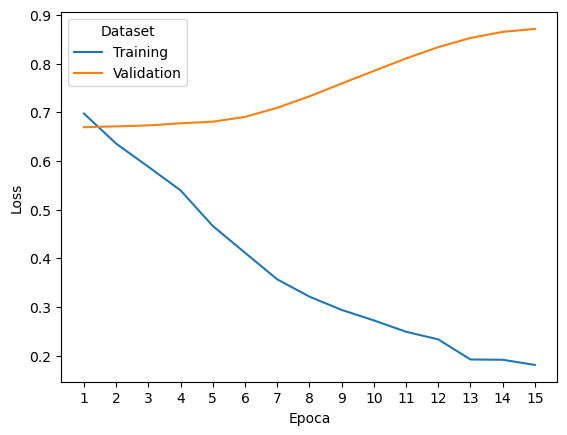

In [23]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 16))
plt.xlabel('Epoca')
plt.savefig(f'loss_curves_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()